In [1]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

print("Size of:")
print("- Training-set:\t\t{}".format(len(mnist.train.labels)))
print("- Test-set:\t\t{}".format(len(mnist.test.labels)))
print("- Validation-set:\t{}".format(len(mnist.validation.labels)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [4]:
# hyper-parameters
logs_path = "./logs/write_summaries"  # path to the folder that we want to save the logs for TensorBoard
learning_rate = 0.001  # The optimization learning rate
epochs = 10  # Total number of training epochs
batch_size = 100  # Training batch size
display_freq = 100  # Frequency of displaying the training results

# Network Parameters
# We know that MNIST images are 28 pixels in each dimension.
img_h = img_w = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_h * img_w

# Number of classes, one class for each of 10 digits.
n_classes = 10

# number of units in the first hidden layer
h1 = 200

In [5]:
# weight and bais wrappers
def weight_variable(name, shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W_' + name,
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)


def bias_variable(name, shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b_' + name,
                           dtype=tf.float32,
                           initializer=initial)


def fc_layer(x, num_units, name, use_relu=True):
    """
    Create a fully-connected layer
    :param x: input from previous layer
    :param num_units: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    :return: The output array
    """
    with tf.variable_scope(name):
        in_dim = x.get_shape()[1]
        W = weight_variable(name, shape=[in_dim, num_units])
        tf.summary.histogram('W', W)
        b = bias_variable(name, [num_units])
        tf.summary.histogram('b', b)
        layer = tf.matmul(x, W)
        layer += b
        if use_relu:
            layer = tf.nn.relu(layer)
        return layer

In [6]:
# Create graph
# Placeholders for inputs (x), outputs(y)
with tf.variable_scope('Input'):
    x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='X')
    tf.summary.image('input_image', tf.reshape(x, (-1, img_w, img_h, 1)), max_outputs=5)
    y = tf.placeholder(tf.float32, shape=[None, n_classes], name='Y')
fc1 = fc_layer(x, h1, 'Hidden_layer', use_relu=True)
output_logits = fc_layer(fc1, n_classes, 'Output_layer', use_relu=False)

# Define the loss function, optimizer, and accuracy
with tf.variable_scope('Train'):
    with tf.variable_scope('Loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=output_logits), name='loss')
        tf.summary.scalar('loss', loss)
    with tf.variable_scope('Optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam-op').minimize(loss)
    with tf.variable_scope('Accuracy'):
        correct_prediction = tf.equal(tf.argmax(output_logits, 1), tf.argmax(y, 1), name='correct_pred')
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
        tf.summary.scalar('accuracy', accuracy)
        # Network predictions
        cls_prediction = tf.argmax(output_logits, axis=1, name='predictions')


# Initializing the variables
init = tf.global_variables_initializer()
merged = tf.summary.merge_all()

W0829 11:55:53.667933  6716 deprecation.py:323] From <ipython-input-6-3225230261b5>:13: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [7]:
# Launch the graph (session)
sess = tf.InteractiveSession() # using InteractiveSession instead of Session to test network in separate cell
sess.run(init)
train_writer = tf.summary.FileWriter(logs_path, sess.graph)
num_tr_iter = int(mnist.train.num_examples / batch_size)
global_step = 0
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    for iteration in range(num_tr_iter):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        global_step += 1
        # Run optimization op (backprop)
        feed_dict_batch = {x: batch_x, y: batch_y}
        _, summary_tr = sess.run([optimizer, merged], feed_dict=feed_dict_batch)
        train_writer.add_summary(summary_tr, global_step)

        if iteration % display_freq == 0:
            # Calculate and display the batch loss and accuracy
            loss_batch, acc_batch = sess.run([loss, accuracy],
                                             feed_dict=feed_dict_batch)
            print("iter {0:3d}:\t Loss={1:.2f},\tTraining Accuracy={2:.01%}".
                  format(iteration, loss_batch, acc_batch))

    # Run validation after every epoch
    feed_dict_valid = {x: mnist.validation.images, y: mnist.validation.labels}
    loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict=feed_dict_valid)
    print('---------------------------------------------------------')
    print("Epoch: {0}, validation loss: {1:.2f}, validation accuracy: {2:.01%}".
          format(epoch + 1, loss_valid, acc_valid))
    print('---------------------------------------------------------')

Training epoch: 1
iter   0:	 Loss=2.28,	Training Accuracy=65.0%
iter 100:	 Loss=0.37,	Training Accuracy=90.0%
iter 200:	 Loss=0.38,	Training Accuracy=90.0%
iter 300:	 Loss=0.24,	Training Accuracy=93.0%
iter 400:	 Loss=0.36,	Training Accuracy=89.0%
iter 500:	 Loss=0.22,	Training Accuracy=94.0%
---------------------------------------------------------
Epoch: 1, validation loss: 0.21, validation accuracy: 93.8%
---------------------------------------------------------
Training epoch: 2
iter   0:	 Loss=0.17,	Training Accuracy=95.0%
iter 100:	 Loss=0.12,	Training Accuracy=97.0%
iter 200:	 Loss=0.15,	Training Accuracy=96.0%
iter 300:	 Loss=0.10,	Training Accuracy=97.0%
iter 400:	 Loss=0.23,	Training Accuracy=91.0%
iter 500:	 Loss=0.14,	Training Accuracy=97.0%
---------------------------------------------------------
Epoch: 2, validation loss: 0.15, validation accuracy: 95.6%
---------------------------------------------------------
Training epoch: 3
iter   0:	 Loss=0.19,	Training Accuracy=95

In [8]:
def plot_images(images, cls_true, cls_pred=None, title=None):
    """
    Create figure with 3x3 sub-plots.
    :param images: array of images to be plotted, (9, img_h*img_w)
    :param cls_true: corresponding true labels (9,)
    :param cls_pred: corresponding true labels (9,)
    """
    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    img_h = img_w = np.sqrt(images.shape[-1]).astype(int)
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape((img_h, img_w)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            ax_title = "True: {0}".format(cls_true[i])
        else:
            ax_title = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_title(ax_title)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    if title:
        plt.suptitle(title, size=20)
    plt.show()
    
    
def plot_example_errors(images, cls_true, cls_pred, title=None):
    """
    Function for plotting examples of images that have been mis-classified
    :param images: array of all images, (#imgs, img_h*img_w)
    :param cls_true: corresponding true labels, (#imgs,)
    :param cls_pred: corresponding predicted labels, (#imgs,)
    """
    # Negate the boolean array.
    incorrect = np.logical_not(np.equal(cls_pred, cls_true))

    # Get the images from the test-set that have been
    # incorrectly classified.
    incorrect_images = images[incorrect]

    # Get the true and predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    cls_true = cls_true[incorrect]

    # Plot the first 9 images.
    plot_images(images=incorrect_images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                title=title)

---------------------------------------------------------
Test loss: 0.07, test accuracy: 97.9%
---------------------------------------------------------


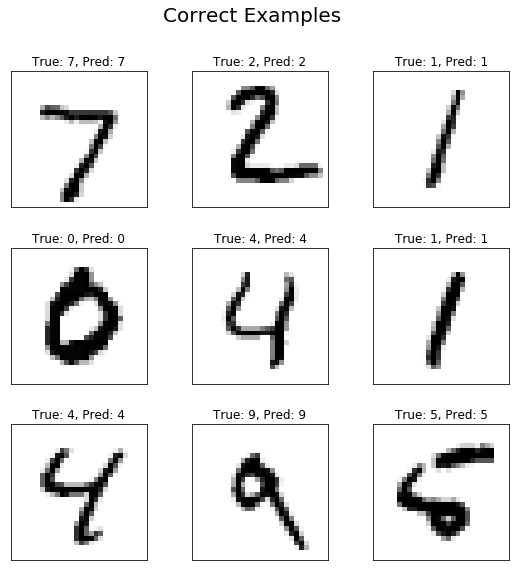

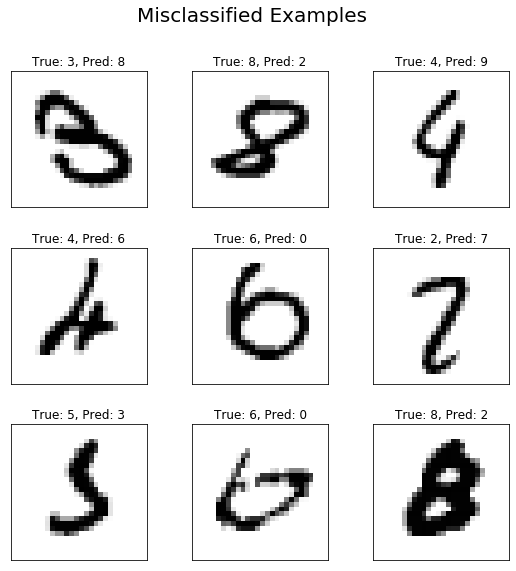

In [9]:
# Test the network after training
# Accuracy
feed_dict_test = {x: mnist.test.images, y: mnist.test.labels}
loss_test, acc_test = sess.run([loss, accuracy], feed_dict=feed_dict_test)
print('---------------------------------------------------------')
print("Test loss: {0:.2f}, test accuracy: {1:.01%}".format(loss_test, acc_test))
print('---------------------------------------------------------')

# Plot some of the correct and misclassified examples
cls_pred = sess.run(cls_prediction, feed_dict=feed_dict_test)
cls_true = np.argmax(mnist.test.labels, axis=1)
plot_images(mnist.test.images, cls_true, cls_pred, title='Correct Examples')
plot_example_errors(mnist.test.images, cls_true, cls_pred, title='Misclassified Examples')

In [10]:
sess.close()